In [1]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, confusion_matrix, roc_auc_score
from transformers import RobertaTokenizer, RobertaForSequenceClassification
import re
from sklearn.utils import class_weight
from tqdm.auto import tqdm


In [2]:
# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
# Load Dataset
print("Loading datasets...")
train_file = "/kaggle/input/c-ours/C_Ours/data_C_Ours_train.csv"
test_file = "/kaggle/input/c-ours/C_Ours/data_C_Ours_test.csv"

train_df = pd.read_csv(train_file)
test_df = pd.read_csv(test_file)

Loading datasets...


In [4]:

# Display class distribution
print("Train data class distribution:")
print(train_df['target'].value_counts(normalize=True))
print("\nTest data class distribution:")
print(test_df['target'].value_counts(normalize=True))


Train data class distribution:
target
1    0.5
0    0.5
Name: proportion, dtype: float64

Test data class distribution:
target
1    0.5
0    0.5
Name: proportion, dtype: float64


In [5]:
# Data Preprocessing Functions
def clean_code(code):
    """Clean and normalize code"""
    # Remove comments (both single line and multi-line)
    code = re.sub(r'//.*?(\n|$)', ' ', code)  # Single line comments
    code = re.sub(r'/\*.*?\*/', ' ', code, flags=re.DOTALL)  # Multi-line comments
    
    # Normalize whitespace
    code = re.sub(r'\s+', ' ', code.strip())
    
    return code

In [6]:
def extract_features(code):
    """Extract additional security features from code"""
    features = {}
    
    # Check for potentially dangerous functions
    dangerous_funcs = ['strcpy', 'strcat', 'sprintf', 'gets', 'scanf']
    for func in dangerous_funcs:
        features[f'uses_{func}'] = 1 if re.search(r'\b{}\b'.format(func), code) else 0
    
    # Check for buffer size checks before operations
    features['has_bounds_check'] = 1 if re.search(r'if\s*\(.*(<=|>=|<|>).*\)', code) else 0
    
    # Check for memory allocation
    features['uses_malloc'] = 1 if re.search(r'\bmalloc\b', code) else 0
    features['uses_free'] = 1 if re.search(r'\bfree\b', code) else 0
    
    # Check for null checks
    features['has_null_check'] = 1 if re.search(r'if\s*\(.*==\s*(NULL|0|nullptr).*\)', code) else 0
    
    # Check for string length operations
    features['uses_strlen'] = 1 if re.search(r'\bstrlen\b', code) else 0
    
    # Check for array indexing
    features['has_array_indexing'] = 1 if re.search(r'\[\s*\w+\s*\]', code) else 0
    
    # Check for pointer arithmetic
    features['has_pointer_arithmetic'] = 1 if re.search(r'(\+\+|\-\-)\s*\w+\s*;|\w+\s*(\+\+|\-\-)|\w+\s*(\+|\-)\s*\d+', code) else 0
    
    return features

In [7]:
# Apply preprocessing to train and test data
print("Preprocessing code samples...")
train_df['cleaned_code'] = train_df['code'].apply(clean_code)
test_df['cleaned_code'] = test_df['code'].apply(clean_code)


Preprocessing code samples...


In [8]:
# Extract additional features
print("Extracting security features...")
train_features = train_df['code'].apply(extract_features).apply(pd.Series)
test_features = test_df['code'].apply(extract_features).apply(pd.Series)


Extracting security features...


In [9]:
# Calculate code complexity metrics as additional features
train_df['code_length'] = train_df['code'].apply(len)
train_df['line_count'] = train_df['code'].apply(lambda x: x.count('\n') + 1)
test_df['code_length'] = test_df['code'].apply(len)
test_df['line_count'] = test_df['code'].apply(lambda x: x.count('\n') + 1)


In [10]:
# Normalize length features
max_length = max(train_df['code_length'].max(), test_df['code_length'].max())
max_lines = max(train_df['line_count'].max(), test_df['line_count'].max())
train_df['norm_length'] = train_df['code_length'] / max_length
train_df['norm_lines'] = train_df['line_count'] / max_lines
test_df['norm_length'] = test_df['code_length'] / max_length
test_df['norm_lines'] = test_df['line_count'] / max_lines

In [11]:
print("Loading tokenizer...")
tokenizer = RobertaTokenizer.from_pretrained("microsoft/codebert-base")

Loading tokenizer...


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/498 [00:00<?, ?B/s]

In [12]:
# Create PyTorch Dataset
class CodeDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        # Remove batch dimension added by tokenizer
        encoding = {k: v.squeeze(0) for k, v in encoding.items()}
        
        return {
            'input_ids': encoding['input_ids'],
            'attention_mask': encoding['attention_mask'],
            'labels': torch.tensor(label, dtype=torch.long)
        }


In [13]:
# Split Train Data
train_funcs, val_funcs, train_labels, val_labels = train_test_split(
    train_df['cleaned_code'].tolist(), 
    train_df['target'].values, 
    test_size=0.2, 
    random_state=42, 
    stratify=train_df['target'].values
)


In [14]:
# Create datasets
print("Creating datasets...")
train_dataset = CodeDataset(train_funcs, train_labels, tokenizer)
val_dataset = CodeDataset(val_funcs, val_labels, tokenizer)
test_dataset = CodeDataset(test_df['cleaned_code'].tolist(), test_df['target'].values, tokenizer)

Creating datasets...


In [15]:
# Calculate class weights
class_counts = np.bincount(train_labels)
class_weights = torch.FloatTensor(1.0 / class_counts)
class_weights = class_weights / class_weights.sum()  # Normalize
class_weights = class_weights.to(device)
print(f"Class weights: {class_weights}")

Class weights: tensor([0.5000, 0.5000], device='cuda:0')


In [16]:
# Create data loaders
batch_size = 8  # Small batch size for better generalization

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


In [17]:
print("Loading model...")
model = RobertaForSequenceClassification.from_pretrained(
    "microsoft/codebert-base",
    num_labels=2,
    hidden_dropout_prob=0.2,
    attention_probs_dropout_prob=0.2
)

Loading model...


pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
# Move model to GPU
model = model.to(device)

In [19]:
def train_epoch(model, dataloader, optimizer, scheduler, class_weights):
    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0
    
    progress_bar = tqdm(dataloader, desc="Training")
    
    for batch in progress_bar:
        # Move batch to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        # Clear gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        logits = outputs.logits
        loss = outputs.loss
        
        # Apply class weights
        if class_weights is not None:
            # Manually calculate cross entropy with weights
            log_probs = torch.nn.functional.log_softmax(logits, dim=1)
            loss = -torch.sum(log_probs * torch.nn.functional.one_hot(labels, num_classes=2) * class_weights) / labels.size(0)
        
        # Backward pass
        loss.backward()
        
        # Clip gradients to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        # Update parameters
        optimizer.step()
        scheduler.step()
        
        # Calculate metrics
        total_loss += loss.item() * labels.size(0)
        pred = torch.argmax(logits, dim=1)
        correct = (pred == labels).sum().item()
        total_correct += correct
        total_samples += labels.size(0)
        
        # Update progress bar
        progress_bar.set_postfix({'loss': loss.item(), 'acc': correct / labels.size(0)})
    
    # Calculate average loss and accuracy
    avg_loss = total_loss / total_samples
    avg_accuracy = total_correct / total_samples
    
    return avg_loss, avg_accuracy


In [20]:
def evaluate(model, dataloader):
    model.eval()
    total_loss = 0
    total_correct = 0
    total_samples = 0
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            # Move batch to device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            logits = outputs.logits
            loss = outputs.loss
            
            # Calculate metrics
            total_loss += loss.item() * labels.size(0)
            probs = torch.softmax(logits, dim=1)
            pred = torch.argmax(logits, dim=1)
            correct = (pred == labels).sum().item()
            total_correct += correct
            total_samples += labels.size(0)
            
            # Store predictions and labels
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    # Calculate average loss and accuracy
    avg_loss = total_loss / total_samples
    avg_accuracy = total_correct / total_samples
    
    return avg_loss, avg_accuracy, all_preds, all_labels, all_probs

In [21]:
num_epochs = 15
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
total_steps = len(train_loader) * num_epochs
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, 
    max_lr=2e-5, 
    total_steps=total_steps
)

# For early stopping
best_val_loss = float('inf')
patience = 2
early_stop_counter = 0
best_model_state = None

# Training loop
print("Starting training...")
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    
    # Train
    train_loss, train_accuracy = train_epoch(model, train_loader, optimizer, scheduler, class_weights)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    
    # Validate
    val_loss, val_accuracy, _, _, _ = evaluate(model, val_loader)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
    
    # Check for early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
        best_model_state = model.state_dict().copy()
        print("New best validation loss - saving model")
    else:
        early_stop_counter += 1
        
    if early_stop_counter >= patience:
        print(f"Early stopping triggered after {epoch+1} epochs")
        break

Starting training...

Epoch 1/15


Training:   0%|          | 0/1083 [00:00<?, ?it/s]

Train Loss: 0.3192, Train Accuracy: 0.6353


Evaluating:   0%|          | 0/271 [00:00<?, ?it/s]

Validation Loss: 0.5767, Validation Accuracy: 0.7133
New best validation loss - saving model

Epoch 2/15


Training:   0%|          | 0/1083 [00:00<?, ?it/s]

Train Loss: 0.2463, Train Accuracy: 0.7756


Evaluating:   0%|          | 0/271 [00:00<?, ?it/s]

Validation Loss: 0.3810, Validation Accuracy: 0.8403
New best validation loss - saving model

Epoch 3/15


Training:   0%|          | 0/1083 [00:00<?, ?it/s]

Train Loss: 0.1786, Train Accuracy: 0.8655


Evaluating:   0%|          | 0/271 [00:00<?, ?it/s]

Validation Loss: 0.3235, Validation Accuracy: 0.8952
New best validation loss - saving model

Epoch 4/15


Training:   0%|          | 0/1083 [00:00<?, ?it/s]

Train Loss: 0.1383, Train Accuracy: 0.9121


Evaluating:   0%|          | 0/271 [00:00<?, ?it/s]

Validation Loss: 0.2885, Validation Accuracy: 0.9086
New best validation loss - saving model

Epoch 5/15


Training:   0%|          | 0/1083 [00:00<?, ?it/s]

Train Loss: 0.1094, Train Accuracy: 0.9367


Evaluating:   0%|          | 0/271 [00:00<?, ?it/s]

Validation Loss: 0.2775, Validation Accuracy: 0.9234
New best validation loss - saving model

Epoch 6/15


Training:   0%|          | 0/1083 [00:00<?, ?it/s]

Train Loss: 0.0862, Train Accuracy: 0.9540


Evaluating:   0%|          | 0/271 [00:00<?, ?it/s]

Validation Loss: 0.3323, Validation Accuracy: 0.9289

Epoch 7/15


Training:   0%|          | 0/1083 [00:00<?, ?it/s]

Train Loss: 0.0655, Train Accuracy: 0.9659


Evaluating:   0%|          | 0/271 [00:00<?, ?it/s]

Validation Loss: 0.3215, Validation Accuracy: 0.9400
Early stopping triggered after 7 epochs


Loaded best model based on validation loss


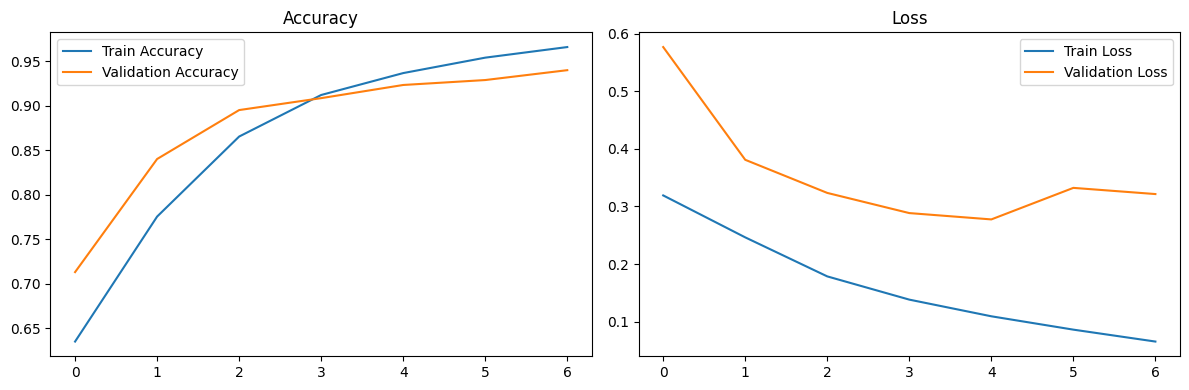


Evaluating on test set...


Evaluating:   0%|          | 0/339 [00:00<?, ?it/s]

Test Loss: 0.2735, Test Accuracy: 0.9460

Classification Report:
                precision    recall  f1-score   support

Non-Vulnerable       0.93      0.96      0.95      1353
    Vulnerable       0.96      0.93      0.95      1353

      accuracy                           0.95      2706
     macro avg       0.95      0.95      0.95      2706
  weighted avg       0.95      0.95      0.95      2706

F1 Score: 0.9460
Precision: 0.9464
Recall: 0.9460


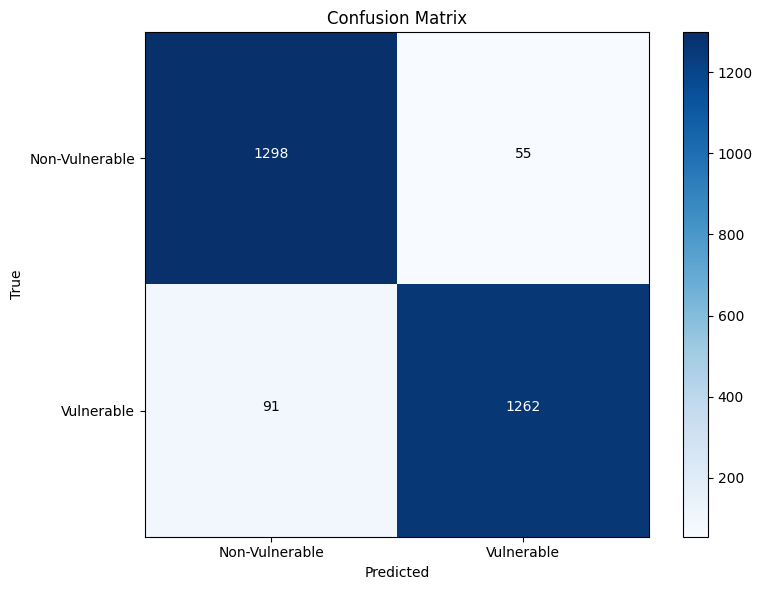

ROC-AUC: 0.9826

Number of misclassified examples: 146

Analyzing a few misclassified examples:

Example #1
True label: Non-Vulnerable
Predicted label: Vulnerable
Confidence: 0.9999
Code snippet (first 200 chars): struct usb_host_endpoint *uvc_find_endpoint(struct usb_host_interface *alts,
		__u8 epaddr)
{
	struct usb_host_endpoint *ep;
	unsigned int i;
	for (i = 0; i < alts->desc.bNumEndpoints; ++i) {
		ep = &...

Example #11
True label: Non-Vulnerable
Predicted label: Vulnerable
Confidence: 0.9997
Code snippet (first 200 chars): void blk_set_cmd_filter_defaults(struct blk_cmd_filter *filter)
{
	__set_bit(TEST_UNIT_READY, filter->read_ok);
	__set_bit(REQUEST_SENSE, filter->read_ok);
	__set_bit(READ_6, filter->read_ok);
	__set_...

Example #44
True label: Vulnerable
Predicted label: Non-Vulnerable
Confidence: 0.9991
Code snippet (first 200 chars): static int masq_inet_event(struct notifier_block *this,
			   unsigned long event,
			   void *ptr)
{
	struct net_device *dev = ((struct in_

In [22]:
# Load best model
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print("Loaded best model based on validation loss")

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.legend()
plt.title("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.legend()
plt.title("Loss")

plt.tight_layout()
plt.savefig('training_history.png')  # Save the plot
plt.show()

# Evaluate on test set
print("\nEvaluating on test set...")
test_loss, test_accuracy, predicted_labels, true_labels, predicted_probs = evaluate(model, test_loader)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=["Non-Vulnerable", "Vulnerable"]))

# F1 Score, Precision, Recall
f1 = f1_score(true_labels, predicted_labels, average="macro")
precision = precision_score(true_labels, predicted_labels, average="macro")
recall = recall_score(true_labels, predicted_labels, average="macro")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ["Non-Vulnerable", "Vulnerable"])
plt.yticks(tick_marks, ["Non-Vulnerable", "Vulnerable"])

# Add text annotations to confusion matrix
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.savefig('confusion_matrix.png')  # Save the plot
plt.show()

# ROC-AUC Score
predicted_probs = np.array(predicted_probs)
roc_auc = roc_auc_score(true_labels, predicted_probs[:, 1])
print(f"ROC-AUC: {roc_auc:.4f}")

# Find misclassified examples for analysis
test_df_with_preds = test_df.copy()
test_df_with_preds['predicted'] = predicted_labels
test_df_with_preds['true'] = true_labels
test_df_with_preds['misclassified'] = test_df_with_preds['predicted'] != test_df_with_preds['true']
test_df_with_preds['confidence'] = [probs[pred] for probs, pred in zip(predicted_probs, predicted_labels)]

misclassified = test_df_with_preds[test_df_with_preds['misclassified']]
print(f"\nNumber of misclassified examples: {len(misclassified)}")

if len(misclassified) > 0:
    print("\nAnalyzing a few misclassified examples:")
    for idx, row in misclassified.head(3).iterrows():
        print(f"\nExample #{idx}")
        print(f"True label: {'Vulnerable' if row['true'] == 1 else 'Non-Vulnerable'}")
        print(f"Predicted label: {'Vulnerable' if row['predicted'] == 1 else 'Non-Vulnerable'}")
        print(f"Confidence: {row['confidence']:.4f}")
        print(f"Code snippet (first 200 chars): {row['code'][:200]}...")

# Save model
print("\nSaving model...")
save_path = "codebert_vulnerability_detector.pt"
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'class_weights': class_weights,
    'tokenizer_name': "microsoft/codebert-base",
}, save_path)
print(f"Model saved to {save_path}")

# Save results to CSV
results_df = pd.DataFrame({
    'true_label': true_labels,
    'predicted_label': predicted_labels,
    'confidence': [probs[pred] for probs, pred in zip(predicted_probs, predicted_labels)],
    'prob_non_vulnerable': predicted_probs[:, 0],
    'prob_vulnerable': predicted_probs[:, 1]
})
results_df.to_csv('prediction_results.csv', index=False)
print("Results saved to prediction_results.csv")